***

# 1. Introduction

In this tutorial, we provide an overview of geothermal wells, well testing in general, and the types of data that are captured during completion testing. We then step though a completion test analysis workflow including:
- Import, formatting and cleaning of pressure, temperature and spinner log (PTS) data and the assocated pump data
- Extraction and plotting of selected temperature logs
- Interpolation of injectivity index from pressure and pump flowrate data
- Detection of feed zones through spinner analysis

Completion testing involves the capture of a large volume of data, which can be cumbersome to analyse in Excel. During this tutoral, we demonstrate efficient and agile processing of these data using Python. Working inside the Jupyter Notebook environment also enables us to generate an annotated record of our work that can be easily repeated or audited, which is worthwhile considering the high-value decisions that are based on completion test analysis. 

We have made this workflow open-source under the Apache 2.0 licence, which is a permissive licence that allows reuse in your own work with attribution to the original authors. If you alter the code or text, then you are required to add a prominent notification that indicates where you have made changes.

Use the following to cite the use of this code, markdown text, and sample dataset:

**GET DOI for release version of our final for the event and generate citation**

***

## 1.1 A definition for geothermal

In this tutorial, we discuss ‘conventional’ geothermal systems where a localised heat source (e.g., shallow crustal magma) or high background heat flow produces a plume of heated fluid that rises buoyantly towards the surface. The hot fluids that are close enough to the surface to be intersected by drilling (a few km) are the conventional geothermal reservoir (Figure 1). At a large scale, we think of these geothermal systems as convection cells that are recharged by regional groundwater. However, they more resemble a thermal conveyer belt at the reservoir scale because fluid enters the hot, productive reservoir though one or more deep upflows and exists though one or more shallow outflow zones. We do not discuss engineered (hot dry rock) geothermal systems or low-temperature sedimentary aquifers. However, the testing methods used in those settings are similar to those described in this tutorial.  

_Figure 1: Cross-section of conventional geothermal reservoir, showing rising plume of buoyant fluid (from Zarrouk and McLean, 2019)._

For geothermal reservoir engineering, it is useful to classify conventional geothermal systems by enthalpy because it informs on the dominant heat transfer mechanism at work in the reservoir: conduction, convection, or advection (Table 1). 

_Table 1: Classification for geothermal systems by enthalpy (from Kaya et al., 2011)._

***

## 1.2 Introduction to geothermal wells

Geothermal wells completions differ significantly from petroleum wells that are typically are only perforated (have access into the reservoir) over very short intervals. Geothermal wells have very long perforated intervals with access to the reservoir, often in excess of 1000 metres in length (Figure 2). 

_Figure 2: Schematic of geothermal well showing feed zones within the production zone accessing the wellbore via the perforated liner (McLean and Zarrouk, 2019)._

Geothermal wells will self-discharge if there is sufficient temperature to generate boiling. In these conditions, flow is driven by the volume expansion of water during boiling rather than high pressures as is the case in groundwater wells. Geothermal wells that are too cool to boil will still flow if there is sufficient hydrostatic head, such as in mountainous areas. Otherwise, these wells are pumped. Pressure gradients in liquid-dominated reservoirs are typically hot hydrostatic (i.e., at a lower pressure than the regional cold hydrostatic gradient). In other words, the pressure is lower inside the reservoir than outside – counter-intuitive but true. 

***

## 1.3 Introduction to well testing

A geothermal well is typically drilled over a period of a few weeks. Immediately after drilling is completed, a program of testing commences. The typical testing sequence is: completion testing, then heating runs, and finally output testing. 

The **completion test** captures pressure, temperature and spinner (PTS) data using a downhole PTS tool (Figure 3). This tool is suspended in the wellbore on a wireline whilst cold water is injected into the well at different rates through the side valve (Figure 4). 

The main objectives of completion testing are to:
1. Identify permeable feed zones in the well, including whether there is a dominant feed zone.
2. Gain an indication of the future potential of the well once in service. 

After completion testing is a set of **heating runs** are conducted in order to observe the pressure and temperature response of the well after cold water injection stops (hence heating commences). Typically at least three heating runs are acquired at increasingly time intervals (i.e., immediately after the completion test, then days later, then weeks or months later depending on the reservoir conditions). These data contribute to Objective 1 of completion testing. 

_Figure 3: Pressure-temperature-spinner (PTS) tool, 2.6 metres in length (Zarrouk and McLean, 2019)._


_Figure 4: Schematic of downhole tool suspended on wireline, including surface equipment setup (Zarrouk and McLean, 2019)._

If the well is destined to be a production well, then it is subjected to output testing (production testing) after heating. Some injection wells are not output tested, as this will never be their function. Typically the well is discharged at multiple flow rates during the output test, while the mass flow and well head pressure recorded for each. From this a a single output curve is generated that shows the behaviour/potential of the well under various operating conditions. PTS data are also captured during discharge in order to see which of the feed zones are contributing to the flow, and how much. 

***

# 2. Import and munge test data

We are working with two sources of data:

1. Pumps operating at the surface (datetime and flow rate)
2. PTS tool in the well (datetime, pressure, temperature, spinner, other tool information)

The following steps take the raw data that has been provided as excel files, imports them as a Pandas dataframe (one called flowrate and the other called pts), and then do some manipulation to generate a nice clean dataset that we can work with.

We will see that data format and data quality are common challenges, especially when datetime is involved. 

In [1]:
import pandas as pd

***

## 2.1. Pump (flowrate) data

We will turn the excel data into a Pandas dataframe that includes:
- A datetime field we can use with the tool data
- Flowrate in the units we need

### 2.1.1 Import flowrate data using Pandas

We read the data in with the header location defined as row 1. This automatically skips row 0 which just contains some text that we don’t want.

In [2]:
flowrate = pd.read_excel(r'Data-FlowRate.xlsx', header=1) 

### Some useful Pandas methods

We will regularly use a set of Pandas methods to check our data as we munge it


Display the first few rows of the dataframe
> df.head() _or_ df.head(n) _to show n rows_

Display the last few rows of the dataframe
> df.tail() _or_ df.tail(n) _to show n rows_

Useful information like the dataframe shape and the data types
> df.info() 

A list of the column headers
> df.columns 

Data types in each coloumn
> df.dtypes

Shape of the dataframe
> df.shape

### 2.1.2 Rename coloums

We do this to remove spaces from the column headers. 

This step is not compulsory, but the presence of spaces in the column names dictates the code format. Once a column has been created, we can interchangeably use the flowrate.raw_datetime or flowrate\['raw_datetime'\] notation. If there are spaces in the column names, the df.column_name notation will not work and we must use the df\['column_name'\] format.


In [3]:
flowrate.columns = ['raw_datetime','flow_Lpm'] 

flowrate.head(2)

,raw_datetime,flow_Lpm
0,2020-12-11T06:00:00+13:00,0.0
1,2020-12-11T06:01:00+13:00,0.0


### 2.1.3 Convert datetime string into Python datetime 

The datetime is in [ISO format](https://en.wikipedia.org/wiki/ISO_8601) and, because it includes the timezone, this is the most globally useful datetime format. 

> 2020-12-11T06:00:00+13:00 

where T indicates the time data and +13:00 is the time shift between UTC and New Zealand where the pumps were recording data. 

In [4]:
flowrate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 711 entries, 0 to 710
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   raw_datetime  711 non-null    object 
 1   flow_Lpm      711 non-null    float64
dtypes: float64(1), object(1)
memory usage: 11.2+ KB


Look at the output above and note that the _raw_datetime_ data type is _object_ and not _datetime_

We will use a two-step process to parse this date:

1. Convert it to a datetime object with the default UTC timezone
2. Convert the datetime object to local time in New Zealand so it can be combined with the pts tool data

In [5]:
# use a method that recognises the ISO format to parse the datetime
from datetime import datetime

list = []
for date in flowrate['raw_datetime']:
    newdate = datetime.fromisoformat(date)
    list.append(newdate)
flowrate['ISO_datetime'] = list

flowrate.tail(2)

,raw_datetime,flow_Lpm,ISO_datetime
709,2020-12-11T17:59:00+13:00,0.0,2020-12-11 17:59:00+13:00
710,2020-12-11T18:00:00+13:00,0.0,2020-12-11 18:00:00+13:00


The method fromisoformate() is new in version Python 3.7

More information can be found [here](https://docs.python.org/3/library/datetime.html) and [here](https://pythontic.com/datetime/date/fromisoformat)

In [6]:
flowrate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 711 entries, 0 to 710
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype                    
---  ------        --------------  -----                    
 0   raw_datetime  711 non-null    object                   
 1   flow_Lpm      711 non-null    float64                  
 2   ISO_datetime  711 non-null    datetime64[ns, UTC+13:00]
dtypes: datetime64[ns, UTC+13:00](1), float64(1), object(1)
memory usage: 16.8+ KB


Now we can see that the data type for the ISO_datetime column is a UTC datetime: datetime64\[ns, UTC+13:00\]

But we need it in local NZ time to combine with the PTS tool data. Luckily, the datetime.strftime method recognises the timezone in the datetime object and does the conversion for us. 

In [7]:
list = []
for date in flowrate.ISO_datetime:
    newdate = pd.to_datetime(datetime.strftime(date,'%Y-%m-%d %H:%M:%S'))
    list.append(newdate)
flowrate['datetime'] = list

flowrate.head()

,raw_datetime,flow_Lpm,ISO_datetime,datetime
0,2020-12-11T06:00:00+13:00,0.0,2020-12-11 06:00:00+13:00,2020-12-11 06:00:00
1,2020-12-11T06:01:00+13:00,0.0,2020-12-11 06:01:00+13:00,2020-12-11 06:01:00
2,2020-12-11T06:02:00+13:00,0.0,2020-12-11 06:02:00+13:00,2020-12-11 06:02:00
3,2020-12-11T06:03:00+13:00,0.0,2020-12-11 06:03:00+13:00,2020-12-11 06:03:00
4,2020-12-11T06:04:00+13:00,0.0,2020-12-11 06:04:00+13:00,2020-12-11 06:04:00


In [8]:
flowrate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 711 entries, 0 to 710
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype                    
---  ------        --------------  -----                    
 0   raw_datetime  711 non-null    object                   
 1   flow_Lpm      711 non-null    float64                  
 2   ISO_datetime  711 non-null    datetime64[ns, UTC+13:00]
 3   datetime      711 non-null    datetime64[ns]           
dtypes: datetime64[ns, UTC+13:00](1), datetime64[ns](1), float64(1), object(1)
memory usage: 22.3+ KB


Now we have a Python datetime object that we can combine with the PTS data which does not have timezone information.  

### 2.1.4 Add a flowrate field in our desired units

Conversions for typical geothermal flowrate units:

- L/sec to t/hr 3.6
- L/min to t/hr 0.060

In [9]:
flowrate['flow_tph'] = flowrate.flow_Lpm * 0.060

flowrate.head(2) # 23

,raw_datetime,flow_Lpm,ISO_datetime,datetime,flow_tph
0,2020-12-11T06:00:00+13:00,0.0,2020-12-11 06:00:00+13:00,2020-12-11 06:00:00,0.0
1,2020-12-11T06:01:00+13:00,0.0,2020-12-11 06:01:00+13:00,2020-12-11 06:01:00,0.0


### 2.1.5 Trim excess coloumns from the dataframe

Now we just drop the columns that we don't want from the dataframe

In [10]:
flowrate.drop(columns = ['raw_datetime', 'flow_Lpm', 'ISO_datetime'], inplace = True)

flowrate.head(2)

,datetime,flow_tph
0,2020-12-11 06:00:00,0.0
1,2020-12-11 06:01:00,0.0


### inplace = True

Each time we do something something like drop columns, we generate a new Pandas dataframe. The argument inplace=True overwrites the old dataframe with the new one. We could have achieved the same thing with assignment:

> flowrate = flowrate.drop(columns = \['raw_datetime', 'flow_Lpm', 'ISO_datetime'\])

***
## 2.2 Pressure, temperature, spinner tool data

We will use a similar process as above to import and munge the pressure, temperature, and spinner (PTS) tool data. However, the PTS dataset includes an addional challenge generated by bad data.


### 2.1.1 Import pts data using Pandas

In [11]:
pts = pd.read_excel(r'Data-PTS.xlsx') 

If you run the cell below, you will see that we have a lot of data in the pts dataframe (101294 rows and 26 columns). 

Efficient handling of large datasets is one of the reasons why Python is better for these kinds of analysis than excel. 

In [12]:
pts.shape

(101294, 26)

In [13]:
pts.head(3)

,Date,Time,Timestamp,DEPTH,SPEED,Cable Weight,WHP,Temperature,Pressure,Frequency,...,SGS Voltage,Internal Temp 1,Internal Temp 2,Internal Temp 3,Cal Temp,Error Code 1,Error Code 2,Error Code 3,Records Saved,Bad Pages
0,yyyy-mm-dd,hh:mm:ss.sss,days,m,m/s,kg,barg,∞C,bara,Hz,...,V,∞C,∞C,∞C,∞C,Count,Count,Count,Count,Count
1,2020-12-11 00:00:00,00:26:44.800000,44176.39357,-6.32025,NaN,24.957275,-0.607066,19.702093,0.498792,40.648876,...,0,24.999414,24.999414,21.8269,0,0,0,0,7948034,0
2,2020-12-11 00:00:00,00:26:45,44176.39358,-6.32025,NaN,25.211151,-0.606777,19.68925,0.485864,41.483227,...,0,24.999414,24.999414,21.8269,0,0,0,0,7948034,0


### 2.2.2 Rename selected coloumn headders

The dataframe has a row of units below the header row that we need to remove. But because we want to know the units of our data, we will rename key columns to remove spaces and include units before dropping the row containing the units.

In [14]:
# dictionary method for renaming some coloums
dict = {
    'DEPTH':'depth_m',
    'SPEED': 'speed_mps',
    'Cable Weight': 'cweight_kg',
    'WHP': 'whp_barg',
    'Temperature': 'temp_degC',
    'Pressure': 'pressure_bara',
    'Frequency': 'frequency_hz'
}

pts.rename(columns=dict, inplace=True)

pts.head(3)

,Date,Time,Timestamp,depth_m,speed_mps,cweight_kg,whp_barg,temp_degC,pressure_bara,frequency_hz,...,SGS Voltage,Internal Temp 1,Internal Temp 2,Internal Temp 3,Cal Temp,Error Code 1,Error Code 2,Error Code 3,Records Saved,Bad Pages
0,yyyy-mm-dd,hh:mm:ss.sss,days,m,m/s,kg,barg,∞C,bara,Hz,...,V,∞C,∞C,∞C,∞C,Count,Count,Count,Count,Count
1,2020-12-11 00:00:00,00:26:44.800000,44176.39357,-6.32025,NaN,24.957275,-0.607066,19.702093,0.498792,40.648876,...,0,24.999414,24.999414,21.8269,0,0,0,0,7948034,0
2,2020-12-11 00:00:00,00:26:45,44176.39358,-6.32025,NaN,25.211151,-0.606777,19.68925,0.485864,41.483227,...,0,24.999414,24.999414,21.8269,0,0,0,0,7948034,0


### 2.2.3 Drop units row

Note that we are using the index value to drop the row of units and then we remake the index. Therefore, if we run this cell over and over, it will keep dropping the first row of data. 

If you are unsure what state your dataframe is in or how many times you have run the cell below, it is useful to run the process from the start again (i.e., go back to step _2.1.1 Import pts data using Pandas_ and work down from there). 

In [15]:
# drop units row using the index value of that row
pts.drop(0, inplace=True)

# re-index the dataframe
pts.reset_index(drop=True, inplace=True)

# WARNING if you run this cell again, it will drop the first line of data


In [16]:
pts.head(2)

,Date,Time,Timestamp,depth_m,speed_mps,cweight_kg,whp_barg,temp_degC,pressure_bara,frequency_hz,...,SGS Voltage,Internal Temp 1,Internal Temp 2,Internal Temp 3,Cal Temp,Error Code 1,Error Code 2,Error Code 3,Records Saved,Bad Pages
0,2020-12-11 00:00:00,00:26:44.800000,44176.39357,-6.32025,NaN,24.957275,-0.607066,19.702093,0.498792,40.648876,...,0,24.999414,24.999414,21.8269,0,0,0,0,7948034,0
1,2020-12-11 00:00:00,00:26:45,44176.39358,-6.32025,NaN,25.211151,-0.606777,19.68925,0.485864,41.483227,...,0,24.999414,24.999414,21.8269,0,0,0,0,7948034,0


### 2.2.4 Recognise bad datetime data & how to handle excel datetime floats

If you investigate the _Time_ column in our pts dataframe, you'll find that the hours are all set to 00 despite the test running for nearly 12 hours and starting at around 9 in the morning. Unfortunately, these kinds of issues with bad data are common and they are why it's important to QA/QC of data when it is acquired. 

We will (reluctantly) use the excel timestamp to generate a new datetime.

An excel timestamp is a floating-point number that reflects the number of days (or part thereof) since a specified start day. There are two systems that start counting from different dates (1900 and 1904) and some fundamental bugs in the way they are implemented. The start date is stored in the excel workbook and we need to know which system is used to correctly generate a datetime. Check out [this documentation](https://openpyxl.readthedocs.io/en/stable/datetime.html) for more information on the challenges of excel timestamps. **The short version is that we should avoid using excel float time whenever possible.** Unfortunately, it is not possible here because of the bad data.

Because we have an xlsx file, will use the openpyxl package to determine the start date in the workbook and parse the excel float to datetime. If you have an xls file, then the xlrd module may be used to achieve the same result.

In [17]:
# first check the start day system in the workbook
import openpyxl

wb = openpyxl.load_workbook(filename="Data-PTS.xlsx")
if wb.epoch == openpyxl.utils.datetime.CALENDAR_WINDOWS_1900: 
    print("This workbook is using the 1900 date system.")
if wb.epoch == openpyxl.utils.datetime.CALENDAR_MAC_1904: 
    print("This workbook is using the 1904 date system.")


This workbook is using the 1900 date system.


As we have the 1900 date system, we can use the default arguments in the from_excel method in the openpyxl utilities. Refer to [the docs](https://openpyxl.readthedocs.io/en/stable/api/openpyxl.utils.datetime.html) for more information.

In [18]:
list = []
for date in pts.Timestamp:
    newdate = openpyxl.utils.datetime.from_excel(date)
    list.append(newdate)
pts['datetime'] = list

In [19]:
pts.head(3)

,Date,Time,Timestamp,depth_m,speed_mps,cweight_kg,whp_barg,temp_degC,pressure_bara,frequency_hz,...,Internal Temp 1,Internal Temp 2,Internal Temp 3,Cal Temp,Error Code 1,Error Code 2,Error Code 3,Records Saved,Bad Pages,datetime
0,2020-12-11 00:00:00,00:26:44.800000,44176.39357,-6.32025,NaN,24.957275,-0.607066,19.702093,0.498792,40.648876,...,24.999414,24.999414,21.8269,0,0,0,0,7948034,0,2020-12-11 09:26:44.448
1,2020-12-11 00:00:00,00:26:45,44176.39358,-6.32025,NaN,25.211151,-0.606777,19.68925,0.485864,41.483227,...,24.999414,24.999414,21.8269,0,0,0,0,7948034,0,2020-12-11 09:26:45.312
2,2020-12-11 00:00:00,00:26:45.200000,44176.39358,-6.32025,NaN,24.981985,-0.606582,19.69439,0.475091,42.96333,...,24.999414,24.999414,21.8269,0,0,0,0,7948034,0,2020-12-11 09:26:45.312


### 2.2.5 Drop unwanted columns from dataframe

There are a lot of columns we do not need for our analysis, so we will drop these


In [20]:
pts.columns

Index(['Date', 'Time', 'Timestamp', 'depth_m', 'speed_mps', 'cweight_kg',
       'whp_barg', 'temp_degC', 'pressure_bara', 'frequency_hz', 'Reed 0',
       'Reed 1', 'Reed 2', 'Reed 3', 'Battery Voltage', 'PRT Ref Voltage',
       'SGS Voltage', 'Internal Temp 1', 'Internal Temp 2', 'Internal Temp 3',
       'Cal Temp', 'Error Code 1', 'Error Code 2', 'Error Code 3',
       'Records Saved', 'Bad Pages', 'datetime'],
      dtype='object')

In [21]:
pts.drop(columns = ['Date', 'Time', 'Timestamp','Reed 0',
       'Reed 1', 'Reed 2', 'Reed 3', 'Battery Voltage', 
       'PRT Ref Voltage','SGS Voltage', 'Internal Temp 1', 
       'Internal Temp 2', 'Internal Temp 3','Cal Temp', 
       'Error Code 1', 'Error Code 2', 'Error Code 3',
       'Records Saved', 'Bad Pages',], inplace = True)

In [22]:
pts.head(3)

,depth_m,speed_mps,cweight_kg,whp_barg,temp_degC,pressure_bara,frequency_hz,datetime
0,-6.32025,NaN,24.957275,-0.607066,19.702093,0.498792,40.648876,2020-12-11 09:26:44.448
1,-6.32025,NaN,25.211151,-0.606777,19.68925,0.485864,41.483227,2020-12-11 09:26:45.312
2,-6.32025,NaN,24.981985,-0.606582,19.69439,0.475091,42.96333,2020-12-11 09:26:45.312


### 2.2.6 Correct the data types

Run the cell below and note that the data types are 'object'. This is because we had a mix of text and numeric when importing these data (remember the units row). We convert the dtype to numeric using the pd.to_numeric method.

In [23]:
pts.dtypes

depth_m                  object
speed_mps                object
cweight_kg               object
whp_barg                 object
temp_degC                object
pressure_bara            object
frequency_hz             object
datetime         datetime64[ns]
dtype: object

In [24]:
pts[
    ['depth_m', 'speed_mps','cweight_kg','whp_barg','temp_degC','pressure_bara','frequency_hz']
] = pts[
    ['depth_m','speed_mps','cweight_kg','whp_barg','temp_degC','pressure_bara','frequency_hz']
    ].apply(pd.to_numeric)

pts.dtypes

depth_m                 float64
speed_mps               float64
cweight_kg              float64
whp_barg                float64
temp_degC               float64
pressure_bara           float64
frequency_hz            float64
datetime         datetime64[ns]
dtype: object

Because methods like ipywidget interactive plots only work with floats, we make and append a [POSIX timestamp](https://en.wikipedia.org/wiki/Unix_time) to each of the dataframes.

In [25]:
def datetime_to_timestamp(dataframe_col):
    '''
    Make POSIX timestamp from Python datetime object

    args: dataframe column containing datetime objects

    returns: list of POSIX timestamp floats 
    '''
    list = []
    for date in dataframe_col:
        timestamp = datetime.timestamp(date)
        list.append(timestamp)
    return list

flowrate['timestamp'] = datetime_to_timestamp(flowrate.datetime)
pts['timestamp'] = datetime_to_timestamp(pts.datetime)

flowrate

,datetime,flow_tph,timestamp
0,2020-12-11 06:00:00,0.0,1.607620e+09
1,2020-12-11 06:01:00,0.0,1.607620e+09
2,2020-12-11 06:02:00,0.0,1.607620e+09
3,2020-12-11 06:03:00,0.0,1.607620e+09
4,2020-12-11 06:04:00,0.0,1.607620e+09
...,...,...,...
706,2020-12-11 17:56:00,0.0,1.607663e+09
707,2020-12-11 17:57:00,0.0,1.607663e+09
708,2020-12-11 17:58:00,0.0,1.607663e+09
709,2020-12-11 17:59:00,0.0,1.607663e+09


***

## We are finished importing and munging the data!

We now have flowrate and pts dataframes that we can work with for the rest of our analysis. 

The steps taken above to import and munge the data are wrapped into custom functions in uitlities.py. 

In the rest of this tutorial, we will call these functions rather than stepping through the method again. 

> from uitlities import*

> flowrate = read_flowrate(r'PTS-2-injection-rate.xlsx')

> pts = read_pts(r'PTS-2.xlsx')


***

# 3. Overview of the completion test data

Katie is making a richer plot for here


In [26]:
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates

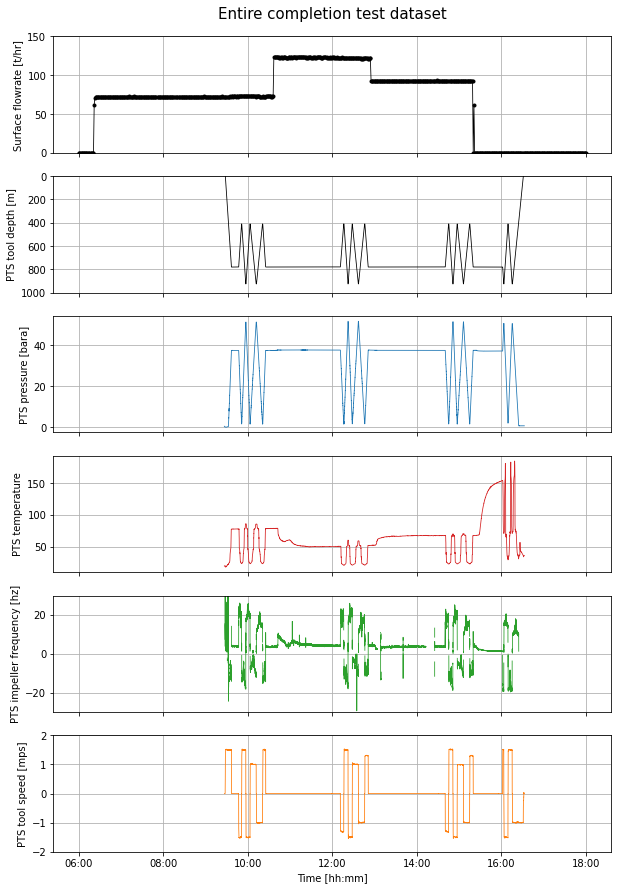

In [27]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, 1,figsize=(10,15),sharex=True)
ax1.set_title('Entire completion test dataset',y=1.1,fontsize=15)

ax1.plot(flowrate.datetime, flowrate.flow_tph, label='Surface pump flowrate', 
    c='k', linewidth=0.8, marker='.')
ax1.set_ylabel('Surface flowrate [t/hr]')
ax1.set_ylim(0,150)
 
ax2.plot(pts.datetime, pts.depth_m, label='PTS tool depth', 
    c='k', linewidth=0.8)
ax2.set_ylabel('PTS tool depth [m]')
ax2.set_ylim(1000,0)
 
ax3.plot(pts.datetime, pts.pressure_bara, label='PTS pressure', 
    c='tab:blue', linewidth=0.8)
ax3.set_ylabel('PTS pressure [bara]')
 
ax4.plot(pts.datetime, pts.temp_degC, label='PTS temperature', 
    c='tab:red', linewidth=0.8)
ax4.set_ylabel('PTS temperature')
 
ax5.plot(pts.datetime, pts.frequency_hz, label='PTS impeller frequency', 
    c='tab:green', linewidth=0.8)
ax5.set_ylim(-30,30)
ax5.set_ylabel('PTS impeller frequency [hz]')
# 1 hz = 60 rpm

ax6.plot(pts.datetime, pts.speed_mps, label='PTS tool speed', 
    c='tab:orange', linewidth=0.8)
ax6.set_ylim(-2,2)
ax6.set_ylabel('PTS tool speed [mps]')

ax6.set_xlabel('Time [hh:mm]')
ax6.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
 
for ax in [ax1,ax2,ax3,ax4,ax5,ax6]:
    ax.grid()
 
plt.show();

***

### Cited references

Kaya, E., Zarrouk, S.J., and O’Sullivan, M.J. (2011): Reinjection in geothermal fields: a review of worldwide experience. Renew. Sustain. Energy Rev. 15 (1), 47-68. 

Zarrouk, S.J. and McLean, K. (2019): Geothermal well test analysis: fundamentals, applications, and advanced techniques. 1st edition, Elsevier. 

***

<p><center>© 2021 <a href="https://www.cubicearth.nz/">Irene Wallis</a> and <a href="https://www.linkedin.com/in/katie-mclean-25994315/">Katie McLean</a> <a href="https://creativecommons.org/licenses/by/4.0/"</a></center></p>

<p><center>Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at <a href="http://www.apache.org/licenses/LICENSE-2.0">http://www.apache.org/licenses/LICENSE-2.0</a></center></p>

<p><center>Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.</center></p>

***